<img src="dh_logo.png" align="right" width="50%">

# Prática Guiada - Sistemas de Recomendação I.

#### Me sendo indivíduos com preferências únicas, consumidores tendem a apresentar comportamentos padronizados, os [sistemas de recomendação](https://towardsdatascience.com/introduction-to-recommender-systems-6c66cf15ada) devem aprender esses padrões e [sugerir novos produtos](https://towardsdatascience.com/tagged/recommendation-system) aos consumidores, de acordo com seus gostos particulares.

#### Sistemas de Recomendação podem ser encontrados:

- Vendas, "Onde comprar...?";
- Alimentaçõ, "Onde comer...?";
- Empregos, "Onde aplicar para uma posição...?";
- Redes sociais, "Que amizade sugerir...?".

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score

#### Vamos instanciar um `dataset` com um conjunto de dados para construirmos um sistema de recomendações. O arquivo `'ex1.csv'` trás dados cujas linhas podem ser interpretadas como usuários e as colunas podem ser interpretadas como items oferecidos pelo serviço.

In [2]:
ex1 = pd.read_csv('ex1.csv')
ex1#.describe()

,0,1,2,3,4,5,6,7,8,9
0,-1.0,-6.0,5.0,-10.0,7.0,6.0,7.0,-2.0,-1.0,-10.0
1,6.0,7.0,3.0,2.0,-9.0,-3.0,8.0,3.0,6.0,-10.0
2,3.0,-10.0,1.0,-8.0,3.0,8.0,4.0,1.0,-6.0,-10.0
3,2.0,-2.0,-3.0,-7.0,-6.0,4.0,5.0,2.0,6.0,-7.0
4,0.0,3.0,-3.0,-9.0,-4.0,5.0,3.0,1.0,7.0,-5.0
5,5.0,NaN,-3.0,-5.0,-10.0,6.0,5.0,3.0,NaN,-5.0


#### Vamos realizar um `scaling` dos dados com o método [`sklearn.preprocessing.MinMaxScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) para facilitar sua modelização.

In [3]:
# Inicializa scaler com range de 1 a 10
sc = MinMaxScaler(feature_range = (1, 10))
#sc
ex1_scaled = pd.DataFrame(sc.fit_transform(ex1)).round(2)
ex1_scaled

,0,1,2,3,4,5,6,7,8,9
0,1.00,3.12,10.00,1.00,10.00,8.36,8.2,1.0,4.46,1.0
1,10.00,10.00,7.75,10.00,1.53,1.00,10.0,10.0,9.31,1.0
2,6.14,1.00,5.50,2.50,7.88,10.00,2.8,6.4,1.00,1.0
3,4.86,5.24,1.00,3.25,3.12,6.73,4.6,8.2,9.31,6.4
4,2.29,7.88,1.00,1.75,4.18,7.55,1.0,6.4,10.00,10.0
5,8.71,NaN,1.00,4.75,1.00,8.36,4.6,10.0,NaN,10.0


#### Podemos interpretar esse conjunto de dados como avaliações / interações de usuários com itens. Então vamos definir os nomes para os índices `rows` e para as colunas `columns`.

In [4]:
rows = [f'user_{i}' for i in range(ex1_scaled.shape[0])]
columns = [f'item_{i}' for i in range(ex1_scaled.shape[1])]

ex1_scaled.columns = columns
ex1_scaled.index = rows
ex1_scaled

,item_0,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9
user_0,1.00,3.12,10.00,1.00,10.00,8.36,8.2,1.0,4.46,1.0
user_1,10.00,10.00,7.75,10.00,1.53,1.00,10.0,10.0,9.31,1.0
user_2,6.14,1.00,5.50,2.50,7.88,10.00,2.8,6.4,1.00,1.0
user_3,4.86,5.24,1.00,3.25,3.12,6.73,4.6,8.2,9.31,6.4
user_4,2.29,7.88,1.00,1.75,4.18,7.55,1.0,6.4,10.00,10.0
user_5,8.71,NaN,1.00,4.75,1.00,8.36,4.6,10.0,NaN,10.0


#### Uma vez contruído o `dataframe` a ser usado, vamos gerar recomendações.

     - Podemos tomar a média das avaliações e sugerir sempre os itens melhor avaliados.

In [5]:
def recommend_mean(n_recommendations, interactions):
    recommendations = interactions.mean(axis = 0).sort_values(ascending = False).index.tolist()[ : n_recommendations]
    return recommendations

In [6]:
#n_recommendations = 3
#ex1_scaled.mean(axis = 0).sort_values(ascending = False).index.tolist()[ : n_recommendations]

In [7]:
recommend_mean(5, ex1_scaled)

['item_5', 'item_7', 'item_8', 'item_0', 'item_1']

#### Há vantagens em sistemas de recomendação, entreleas estão:

- Exposição ampla aos items disponíveis;
- Encorajamento do uso contínuo e compra de produtos;
- Experiência personalizada;

#### Entretanto recomendar produtos com base na média das avaliações tem alguns problemas:

- Sempre os mesmos produtos;
- Ciclo vicioso;
- Sem personalização;
- Dificuldade de inserção de novos produtos;.

#### É necessária, então, uma nova estratégia. Talvez buscar por usuários similares. A questão é como identificar usuários similares a partir de suas avaliações.

- Queremos recomendar itens ainda não vistos para o usuário `user_5`. Como identificar se ele tem mais propensão a gostar do `item 8` ou do `item 1`?

#### Um sistema de recomendação costuma ter duas aproximações. A Filtragem Colaborativa, em que os dados de usuários com preferências semelhantes são utilizados para a sugestão de itens e Filtragem Baseada em Conteúdo, em que os dados dos próprios usuários são utilizados para que o sistema faça sugestões de items semelhantes.

<img src="RECOMMENDATION_SYSTEMS.png" width="463" height="301" />

- [`Collaborative Filtering`](https://towardsdatascience.com/tagged/collaborative-filtering): Dados de usuários semelhantes são utilizados para as recomendações items.

- [`Content Based Filtering`](https://towardsdatascience.com/tagged/content-based-filtering): Dados do próprio usuário são utilizados para as recomendações de items semelhantes.

<h1><center>As preferências semelhantes anteriores podem informar as preferências futuras</center></h1>

### Collaborative Filtering

#### A filtragem colaborativa, ou [`Collaborative Filtering`](https://towardsdatascience.com/essentials-of-recommendation-engines-content-based-and-collaborative-filtering-31521c964922) tenta descobrir quais itens são populares entre os outros usuários e que poderiam ser recomendados para um usuário específico.

#### Correlação: 

#### A [correlação de Pearson](https://towardsdatascience.com/tagged/pearson-correlation) mede quão bem a distribuição de duas variáveis pode ser representada por uma reta. Assim, usuários que apresentem uma boa correlação positiva tendem a avaliar os itens de forma parecida.

In [8]:
corr_matrix_user = ex1_scaled.T.corr()
corr_matrix_user

,user_0,user_1,user_2,user_3,user_4,user_5
user_0,1.000000,-0.363247,0.450552,-0.430991,-0.296703,-0.731074
user_1,-0.363247,1.000000,-0.410021,0.018939,-0.369807,-0.018451
user_2,0.450552,-0.410021,1.000000,-0.158850,-0.251396,-0.080114
user_3,-0.430991,0.018939,-0.158850,1.000000,0.776855,0.894062
user_4,-0.296703,-0.369807,-0.251396,0.776855,1.000000,0.658376
user_5,-0.731074,-0.018451,-0.080114,0.894062,0.658376,1.000000


#### Encontramos os usuários mais correlacionados com o `user_5`.

In [9]:
corr_matrix_user['user_5'].sort_values(ascending = False)

user_5    1.000000
user_3    0.894062
user_4    0.658376
user_1   -0.018451
user_2   -0.080114
user_0   -0.731074
Name: user_5, dtype: float64

#### Vemos que o usuário que apresenta maior correlação com o usuário `user_5` é o usuário `user_3`. Observe gráfico.

In [10]:
#ex1_scaled = ex1_scaled.fillna(0)
ex1_scaled
#ex1_scaled.loc['user_5']
#ex1_scaled.shape[1]

,item_0,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9
user_0,1.00,3.12,10.00,1.00,10.00,8.36,8.2,1.0,4.46,1.0
user_1,10.00,10.00,7.75,10.00,1.53,1.00,10.0,10.0,9.31,1.0
user_2,6.14,1.00,5.50,2.50,7.88,10.00,2.8,6.4,1.00,1.0
user_3,4.86,5.24,1.00,3.25,3.12,6.73,4.6,8.2,9.31,6.4
user_4,2.29,7.88,1.00,1.75,4.18,7.55,1.0,6.4,10.00,10.0
user_5,8.71,NaN,1.00,4.75,1.00,8.36,4.6,10.0,NaN,10.0


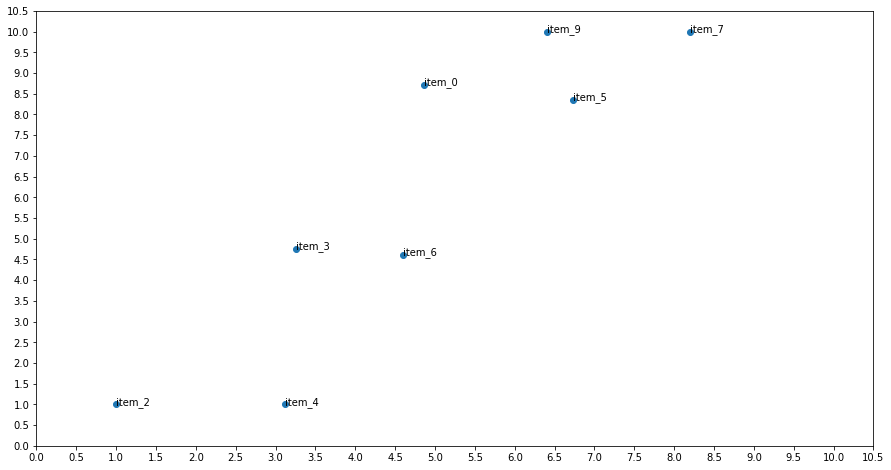

In [11]:
# Gráfico de notas de user_3 e user_5 para todos os itens
plt.figure(figsize = (15, 8))
plt.scatter(ex1_scaled.loc['user_3'], 
            ex1_scaled.loc['user_5']
           )

for i in range(ex1_scaled.shape[1]):
    plt.annotate(ex1_scaled.loc['user_3'].index[i],
                 (ex1_scaled.loc['user_3'].values[i], 
                  ex1_scaled.loc['user_5'].values[i])
                )
    
plt.xticks(np.arange(0, 11, 0.5))
plt.yticks(np.arange(0, 11, 0.5))
plt.show()

#### Parece que de fato, conseguimos ajustar uma reta sobre esses valores. Isso quer dizer que estes dois usuários avaliam os itens de forma muito semelhante. Então é razoável assumir que o usuário `user_5` avaliaria de forma semelhante ao usuário `user_3` os itens que ele ainda não viu.

In [12]:
def recommend_corr(user_idx, n_recommendations, interactions):
    user = f'user_{user_idx}'
    most_similar_user = (interactions.T.corr().drop(user)[user].sort_values(ascending = False).index[0])

    unseen_items = [item for item in interactions.loc[user].index if np.isnan(interactions.loc[(user), item])]

    unseen_scores = interactions.loc[user].fillna(interactions.loc[most_similar_user])[unseen_items]
    print('Usuário mais similar:', 
          most_similar_user
         )
    return unseen_scores.sort_values(ascending = False).index.tolist()[:n_recommendations]

#### Podemos gerar recomendação baseada em correlação entre usuários

In [13]:
recommend_corr(5, 1, ex1_scaled)

Usuário mais similar: user_3


['item_8']

#### Podemos também usar o modelo dos `k` vizinhos mais próximos ([`kNN`](https://medium.com/learning-machine-learning/recommending-animes-using-nearest-neighbors-61320a1a5934)).

In [14]:
def recommend_knn(user_idx, interactions, n_recommendations, n_neighbors, distance_metric):
    
    knn = KNeighborsRegressor(n_neighbors = n_neighbors, 
                              weights = 'distance', 
                              metric = distance_metric
                             )
    
    user = f'user_{user_idx}'

    unseen_items = [item for item in interactions.columns if np.isnan(interactions.loc[user, item])]
    
    X = (interactions.drop(user).drop(unseen_items, axis = 1))
    
    y = (interactions.drop(user)[unseen_items])
    
    knn.fit(X, y)
    
    X_user = interactions.loc[[user]].drop(unseen_items, axis = 1)
    
    interactions_unseen = knn.predict(X_user)
    
    interactions_user = interactions.copy()
    interactions_user.loc[user, unseen_items] = interactions_unseen
    
    print('Usuário mais similar:')
    display(interactions_user.loc[user, unseen_items].sort_values(ascending = False))
    
    return interactions_user.loc[user, unseen_items].sort_values(ascending = False).index.tolist()[:n_recommendations]


#### Usuários como o `user_5` também viram:

In [15]:
recommend_knn(5, ex1_scaled, 1, 3, 'cosine')

Usuário mais similar:


item_8    8.791112
item_1    5.395276
Name: user_5, dtype: float64

['item_8']

### Content Based Filtering

#### A [Filtragem baseada em conteúdo](https://towardsdatascience.com/tagged/content-based-filtering) tenta descobrir quais são os aspectos preferidos de um item para o usuário e então faz recomendações de itens que compartilham desses aspectos. Essa abordagem recomenda itens semelhantes aos que o usuário já consumiu.

#### Vamos criar uma nova observação no `dataset` `ex1_scaled`.

In [16]:
ex1_scaled.loc['user_6', 
               ['item_0', 'item_1', 'item_2']
              ] = [4., 10., 6.]

ex1_scaled

,item_0,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9
user_0,1.00,3.12,10.00,1.00,10.00,8.36,8.2,1.0,4.46,1.0
user_1,10.00,10.00,7.75,10.00,1.53,1.00,10.0,10.0,9.31,1.0
user_2,6.14,1.00,5.50,2.50,7.88,10.00,2.8,6.4,1.00,1.0
user_3,4.86,5.24,1.00,3.25,3.12,6.73,4.6,8.2,9.31,6.4
user_4,2.29,7.88,1.00,1.75,4.18,7.55,1.0,6.4,10.00,10.0
user_5,8.71,NaN,1.00,4.75,1.00,8.36,4.6,10.0,NaN,10.0
user_6,4.00,10.00,6.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Agora dispomos também de algumas informações sobre os filmes, vamos ler um novo `dataset`

In [17]:
items = pd.read_csv('ex2.csv', 
                    index_col = 0
                   )
items

,duration_min,budget_M,year,genre
item_0,105,13,2004,action
item_1,96,0,2019,comedy
item_2,118,6,2001,drama
item_3,80,9,2002,drama
item_4,105,4,2006,action
item_5,106,11,2009,action
item_6,89,16,2004,action
item_7,90,11,2009,action
item_8,126,14,2010,action
item_9,87,5,2008,drama


#### Criamos vairáveis `dummies` para o atributo `'genre'` e reescalonamos os valores.

In [18]:
items_scaled = pd.get_dummies(items)

sc = MinMaxScaler()
items_scaled = pd.DataFrame(sc.fit_transform(items_scaled), 
                            columns = items_scaled.columns, 
                            index = items_scaled.index
                           )
items_scaled

,duration_min,budget_M,year,genre_action,genre_comedy,genre_drama
item_0,0.543478,0.8125,0.166667,1.0,0.0,0.0
item_1,0.347826,0.0000,1.000000,0.0,1.0,0.0
item_2,0.826087,0.3750,0.000000,0.0,0.0,1.0
item_3,0.000000,0.5625,0.055556,0.0,0.0,1.0
item_4,0.543478,0.2500,0.277778,1.0,0.0,0.0
item_5,0.565217,0.6875,0.444444,1.0,0.0,0.0
item_6,0.195652,1.0000,0.166667,1.0,0.0,0.0
item_7,0.217391,0.6875,0.444444,1.0,0.0,0.0
item_8,1.000000,0.8750,0.500000,1.0,0.0,0.0
item_9,0.152174,0.3125,0.388889,0.0,0.0,1.0


#### A seguir criamos uma função que recomenda itens semelhantes.

In [19]:
def recommend_similar_item(user_idx, interactions, items_info, n_recommendations, distance):

    user = f'user_{user_idx}'

    favorite_item = interactions.loc[user].sort_values(ascending = False).index.tolist()[0]

    if distance == 'euclidean':
        distances = [np.linalg.norm(items_info.loc[favorite_item] - items_info.loc[item]) for item in items_info.index]

    similar_items = items_info.copy()
    similar_items['distance_to_favorite'] = distances

    return similar_items.drop(favorite_item).sort_values(by = 'distance_to_favorite').index.tolist()[ : n_recommendations]

#### Vamos fazer uma recomendação para o usuário `user_6` com base em itens similares ao seu item favorito.

In [20]:
recommend_similar_item(6, 
                       ex1_scaled, 
                       items_scaled, 
                       3, 
                       'euclidean'
                      )

['item_9', 'item_4', 'item_7']

#### Lê-mos dois novos `dataset`.

In [21]:
users = pd.read_csv('ex3.csv', 
                    sep = ';', 
                    index_col = 0
                   )

movies = pd.read_csv('ex3-2.csv', 
                     sep = ';', 
                     index_col = 0
                    )

#### E criamos umas matriz de interação de usuários com itens.

In [22]:
users_movies = pd.DataFrame(np.dot(users.to_numpy(), movies.T.to_numpy()), 
                            index = users.index, 
                            columns = movies.index
                           )
users_movies

,item_0,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9
user_0,1,5,4,1,4,2,7,3,5,6
user_1,4,6,2,4,2,1,7,5,6,3
user_2,5,7,2,5,2,3,10,8,7,5
user_3,2,4,2,2,2,1,5,3,4,3
user_4,3,8,5,3,5,2,10,5,8,7
user_5,1,3,2,1,2,5,8,6,3,7


### Métricas de Similaridade

#### Cosine Similarity

#### A semelhança entre dois itens pode ser medida com a aplicação do conceito de [similaridade de cosenos](https://medium.com/@mark.rethana/building-a-song-recommendation-system-using-cosine-similarity-and-euclidian-distance-748fdfc832fd).

<img src="Similaridade.png" width="585" height="424" />

 - Verstáil, funciona para variáveis numéricas e categóricas;
 - Considera como similares usuários com interações proporcionais.

#### A seguir podemos criar uma matriz de similaridade entre os itens dada pelos cossenos dos ângulos entre os vetores de cada usuário. Faremos isso com o método [`sklearn.metrics.pairwise.cosine_similarity()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html)

In [23]:
pd.DataFrame(cosine_similarity(ex1_scaled.drop(['user_5', 'user_6'])), 
             index = ex1_scaled.index[:5], 
             columns = ex1_scaled.index[:5]
            )

,user_0,user_1,user_2,user_3,user_4
user_0,1.000000,0.583907,0.807719,0.613416,0.561033
user_1,0.583907,1.000000,0.608159,0.802004,0.632819
user_2,0.807719,0.608159,1.000000,0.714895,0.610336
user_3,0.613416,0.802004,0.714895,1.000000,0.937147
user_4,0.561033,0.632819,0.610336,0.937147,1.000000


#### Jaccard Index


#### O índice de Jaccard, ou coeficiente de similaridade de Jaccard é definido como o tamanho da interseção dividido pelo tamanho da união de dois conjuntos de rótulos, é usado para comparar o conjunto de rótulos previstos para uma amostra com o conjunto correspondente de rótulos em `y_true`.

<img src="jaccardIndex.png" width="700" height="470" />

#### A similaridade de Jaccard, aplicável com o método [`sklearn.metrics.jaccard_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html) é útil apenas quando os vetores contêm valores binários. Se eles tiverem classificações ou classificações que podem assumir vários valores, a similaridade de Jaccard não é aplicável.

    - Mais apropriada para variáveis categóricas

#### A seguir calculamos o índice de jaccard para dois filmes.

In [24]:
jaccard_score(movies.loc['item_1'].values, 
              movies.loc['item_8'].values
             )

1.0